### Problem 1 :

#### Definition of the MLP class:

In [3]:
# For live plot:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

def live_plot(data_dict1, title1, data_dict2, title2, figsize=(7,5), bestEpoch=0):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.subplot(1,2,1)
    for label,data in data_dict1.items():
        plt.plot(data, label=label)
        if label == 'validation accuracy':
            plt.plot(bestEpoch, data[bestEpoch], "ro")
    plt.title(title1)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left')
    plt.subplot(1,2,2)
    for label,data in data_dict2.items():
        plt.plot(data, label=label)
        if label == 'validation loss':
            plt.plot(bestEpoch, data[bestEpoch], "ro")
    plt.title(title2)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left')
    plt.show();

# For NN operations:
import numpy as np
import pickle
import copy

"""MLP class :

The model implemented as follows :
Each layers is represented by a b vector (biases) and a W matrix (weights)
These are referenced by the weights dictionary. The format is :
self.weights[f"X{n}"] where X = b, W
NB : In our implementation, all matrices are transposed compared to the class notations
"""
class NN(object):
    
    def __init__(self,
                 hidden_dims=(1024, 2048), # dimensions of each hidden layers
                 n_hidden=2, # number of hidden layers
                 mode='train', # current mode : train/test
                 datapath=None, # path where to find the .pkl file
                 model_path=None, # path where to save/load the model 
                 epsilon = 1e-6, # for cross entropy calculus stability : log(x) = log(epsilon) if x < epsilon
                 lr = 1e-1, # learning rate
                 n_epochs = 1000, # max number of epochs
                 batch_size = 1000,  # batch size for training
                 compute_biases = True): # whether biases are used or not
        
        assert len(hidden_dims) == n_hidden, "Hidden dims mismatch!"
        
        self.hidden_dims = hidden_dims
        self.n_hidden = n_hidden
        self.mode = mode
        self.datapath = datapath
        self.model_path = model_path
        self.epsilon = epsilon
        self.lr = lr
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.compute_biases = compute_biases
        
        self.dataplot1 = collections.defaultdict(list)
        self.dataplot2 = collections.defaultdict(list)
        
        self.bestValLoss = np.Infinity # min value of the validation loss
        self.bestEpoch = 0 # epoch where we reached the min value of the validation loss
        self.bestWeights = None # optimal weights dictionary (contains biases when compute_biases=True)
        
        # train, validation and test sets :
        u = pickle._Unpickler(open(datapath, 'rb'))
        u.encoding = 'latin1'
        self.tr, self.va, self.te = u.load()

    def initialize_weights(self, dims, method):
        """
        Initializes the weights and biases according to the specified method
        Parameters :
        - dims: (list of two integers) - the size of input/output layers
        - method: (string) - initializes the weight matrices
            -> "zero" for a Zero initialisation of the weights
            -> "normal" for a Normal initialisation of the weights
            -> "glorot" for a Uniform initialisation of the weights
        :return: None
        """
        if self.mode == "train":
            self.weights = {}
            all_dims = [dims[0]] + list(self.hidden_dims) + [dims[1]]
            print("Layers dimensions are : ", all_dims)
            for layer_n in range(1, self.n_hidden + 2):
                if method == "zero":
                    self.weights[f"W{layer_n}"] = np.zeros(shape=(all_dims[layer_n - 1],all_dims[layer_n])).astype('float64')
                elif method == "normal":
                    #Be aware of the error you get "true divide", can be solved by dividing by dim_layer[n-1] 
                    self.weights[f"W{layer_n}"] = np.random.normal(loc=0.0, scale=1.0, size=(all_dims[layer_n - 1],
                                                                                             all_dims[layer_n])).astype('float64')/all_dims[layer_n-1]
                elif method == "glorot":
                    b = np.sqrt(6.0/(all_dims[layer_n]+all_dims[layer_n-1]))
                    self.weights[f"W{layer_n}"] = np.random.uniform(low=-b, high=b, size=(all_dims[layer_n - 1],
                                                                                            all_dims[layer_n])).astype('float64')
                else:
                    raise Exception("The provided name for the initialization method is invalid.")
                
                if self.compute_biases:
                    self.weights[f"b{layer_n}"] = np.zeros((1, all_dims[layer_n]))
                    
        elif self.mode == "test":
            pass
        else:
            raise Exception("Unknown Mode!")

    def activation(self, input, prime=False):  # Prime for Step function, else ReLu
        if prime:
            return input > 0
        return np.maximum(0, input)

    def softmax(self, input):  # Computes the softmax of the input
        """
        Documentation
        """
        Z = np.exp(input - np.max(input)) # softmax(x-C) = softmax(x) (stability)
        return Z / np.sum(Z, axis=1, keepdims=True)
    
    def forward(self, input):  # Forward propagation : computes the outputs (cache) from the input
        """
        Documentation
        """
        cache = {"H0": input}
        for layer in range(1, self.n_hidden + 1):
            if self.compute_biases:
                cache[f"A{layer}"] = cache[f"H{layer-1}"] @ self.weights[f"W{layer}"] + self.weights[f"b{layer}"]
            else:
                cache[f"A{layer}"] = cache[f"H{layer-1}"] @ self.weights[f"W{layer}"]
            cache[f"H{layer}"] = self.activation(cache[f"A{layer}"])
        layer = self.n_hidden + 1
        if self.compute_biases:
            cache[f"A{layer}"] = cache[f"H{layer-1}"] @ self.weights[f"W{layer}"] + self.weights[f"b{layer}"]
        else:
            cache[f"A{layer}"] = cache[f"H{layer-1}"] @ self.weights[f"W{layer}"]
        cache[f"H{layer}"] = self.softmax(cache[f"A{layer}"]) # softmax on last layer
        return cache
    
    def backward(self, cache, labels):  # Backward propagation : computes the gradients from the outputs (cache)
        """
        Documentation
        """
        output = cache[f"H{self.n_hidden+1}"]
        grads = {f"dA{self.n_hidden+1}": - (labels - output)}
        for layer in range(self.n_hidden + 1, 0, -1):
            # the following operation averages at once all the matrices
            # that we would have calculated for each example of the minibatch if we had not represented it in matrix form :
            grads[f"dW{layer}"] = cache[f"H{layer-1}"].T @ grads[f"dA{layer}"] / self.batch_size
            # we need to do the same for the biases gradients :
            if self.compute_biases:
                grads[f"db{layer}"] = np.mean(grads[f"dA{layer}"], axis=0, keepdims=True)
            if layer > 1:
                grads[f"dH{layer-1}"] = grads[f"dA{layer}"] @ self.weights[f"W{layer}"].T
                grads[f"dA{layer-1}"] = grads[f"dH{layer-1}"] * self.activation(cache[f"A{layer-1}"], prime=True)
        return grads
    
    def update(self, grads):  # To update the weights and the biases
        """
        Documentation
        """
        for layer in range(1, self.n_hidden + 1):
            self.weights[f"W{layer}"] = self.weights[f"W{layer}"] - self.lr * grads[f"dW{layer}"]
            if self.compute_biases:
                self.weights[f"b{layer}"] = self.weights[f"b{layer}"] - self.lr * grads[f"db{layer}"]
    
    def loss(self, prediction, labels):  # Computes the cross entropy
        """
        Documentation
        """
        prediction[np.where(prediction < self.epsilon)] = self.epsilon
        prediction[np.where(prediction > 1 - self.epsilon)] = 1 - self.epsilon
        return -1 * np.sum(labels * np.log(prediction)) / prediction.shape[0]
    
    def computeLossAndAccuracy(self, X, y):  # Stores the accuracy/loss of the train/validation sets
        """
        Documentation
        """
        X_train, y_train = self.tr
        on_y = np.eye(np.max(y_train) - np.min(y_train) + 1)[y]
        vCache = self.forward(X)
        predicted_y = np.argmax(vCache[f"H{self.n_hidden + 1}"], axis=1)
        vAccuracy = np.mean(y == predicted_y)
        vLoss = self.loss(vCache[f"H{self.n_hidden+1}"], on_y)
        return vLoss, vAccuracy
    
    def train(self, initializationMethod):
        """
        Documentation
        """
        X_train, y_train = self.tr
        y_onehot = np.eye(np.max(y_train) - np.min(y_train) + 1)[y_train]
        dims = [X_train.shape[1], y_onehot.shape[1]]
        self.initialize_weights(dims, initializationMethod)
        n_batches = int(np.ceil(X_train.shape[0] / self.batch_size))

        for epoch in range(self.n_epochs):
            predictedY = np.zeros_like(y_train)
            for batch in range(n_batches):
                minibatchX = X_train[self.batch_size * batch:self.batch_size * (batch + 1), :]
                minibatchY = y_onehot[self.batch_size * batch:self.batch_size * (batch + 1), :]
                cache = self.forward(minibatchX)
                grads = self.backward(cache, minibatchY)
                self.update(grads)
                predictedY[self.batch_size * batch:self.batch_size * (batch + 1)] = np.argmax(
                    cache[f"H{self.n_hidden + 1}"], axis=1)
            
            X_tr, y_tr = self.tr
            trLoss, trAccuracy = self.computeLossAndAccuracy(X_tr, y_tr)
            X_val, y_val = self.va
            valLoss, valAccuracy = self.computeLossAndAccuracy(X_val, y_val)
            if valLoss < self.bestValLoss:
                self.bestValLoss = valLoss
                self.bestEpoch = epoch
                self.bestWeights = copy.deepcopy(self.weights)
            
            self.dataplot1['train accuracy'].append(trAccuracy)
            self.dataplot1['validation accuracy'].append(valAccuracy)
            self.dataplot2['train loss'].append(trLoss)
            self.dataplot2['validation loss'].append(valLoss)
            live_plot(self.dataplot1, "Accuracy", self.dataplot2, "Loss", (14,5), self.bestEpoch)
            
    def test(self):
        pass

#### Test of the NN class with MNIST:

### <font color="red"> On plot la loss/accuracy du train et validation

In [ ]:
#SGD
neural_net = NN(hidden_dims=(500, 400),
                n_hidden=2, # number of hidden layers
                mode='train', # current mode : train/test
                datapath="mnist.pkl", # path where to find the .pkl file
                model_path=None, # path where to save/load the model 
                epsilon = 1e-8, # for cross entropy calculus stability : log(x) = log(epsilon) if x < epsilon
                lr = 5e-1, # learning rate
                n_epochs = 1000, # max number of epochs
                batch_size = 1, # batch size for training
                compute_biases = True) # whether biases are used or not
neural_net.train("glorot")

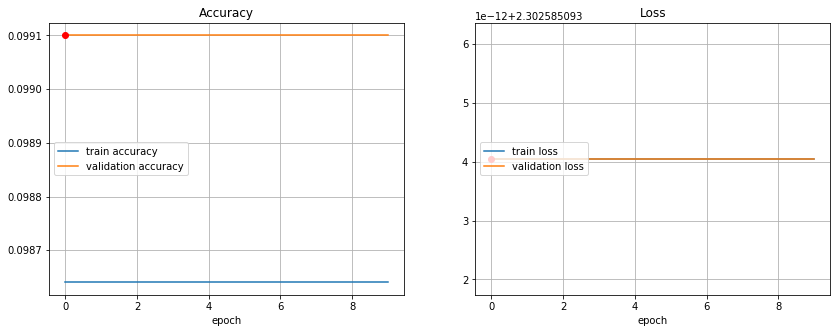

In [3]:
#Zero_Init
neural_net = NN(hidden_dims=(500, 400),
                n_hidden=2, # number of hidden layers
                mode='train', # current mode : train/test
                datapath="mnist.pkl", # path where to find the .pkl file
                model_path=None, # path where to save/load the model 
                epsilon = 1e-8, # for cross entropy calculus stability : log(x) = log(epsilon) if x < epsilon
                lr = 5e-1, # learning rate
                n_epochs = 10, # max number of epochs
                batch_size = 1000, # batch size for training
                compute_biases = True) # whether biases are used or not
neural_net.train("zero")

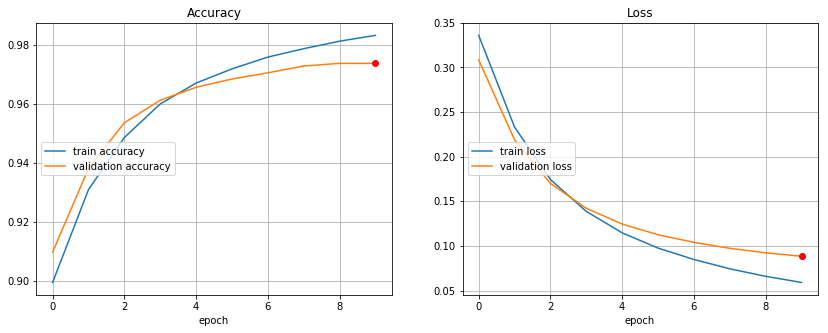

In [6]:
#Normal_Init
neural_net = NN(hidden_dims=(500, 400),
                n_hidden=2, # number of hidden layers
                mode='train', # current mode : train/test
                datapath="../mnist.pkl", # path where to find the .pkl file
                model_path=None, # path where to save/load the model 
                epsilon = 1e-8, # for cross entropy calculus stability : log(x) = log(epsilon) if x < epsilon
                lr = 5e-1, # learning rate
                n_epochs = 10, # max number of epochs
                batch_size = 10, # batch size for training
                compute_biases = True) # whether biases are used or not
neural_net.train("normal")

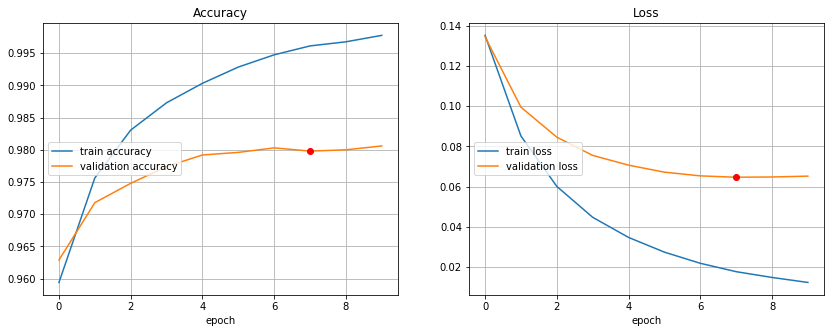

In [2]:
#Glorot_Init
neural_net = NN(hidden_dims=(500, 400),
                n_hidden=2, # number of hidden layers
                mode='train', # current mode : train/test
                datapath="mnist.pkl", # path where to find the .pkl file
                model_path=None, # path where to save/load the model 
                epsilon = 1e-8, # for cross entropy calculus stability : log(x) = log(epsilon) if x < epsilon
                lr = 5e-1, # learning rate
                n_epochs = 10, # max number of epochs
                batch_size = 100, # batch size for training
                compute_biases = True) # whether biases are used or not
neural_net.train("glorot")

In [ ]:
# Random search over these params : Model_architechture (n_hidden, hidden_dims), lr,non_linearity, epoch, batch..